Current working directory: c:\Users\rodrigo.miranda\Mi unidad (rodrigo.miranda@acad.ufsm.br)\Doutorado\IA\jupyter-VSC\VAE
Available model directories:
1: dataset
2: logs
3: simulations_old
4: tensorboard_old
5: vae_model_kl
6: vae_model_kl2
7: vae_model_kl3
8: vae_model_savedmodel
9: vae_model_savedmodel_5MS_100kS_Square
10: vae_model_savedmodel_disk_10MS
11: vae_model_savedmodel_disk_1MS
12: vae_model_savedmodel_led_model
13: vae_model_savedmodel_led_model2
14: vae_model_savedmodel_led_model3
15: vae_model_savedmodel_novo-disk
16: vae_model_savedmodel_paper
17: vae_model_savedmodel_paper2
18: vae_model_savedmodel_phase
19: vae_model_savedmodel_round
20: vae_model_savedmodel_Square_less_evm
21: vae_model_savedmodel_test
22: vae_model_savedmodel_test-novo-fullsquare
Selected model directory: vae_model_savedmodel_Square_less_evm
Model file found.
Model successfully loaded.
Predictions completed for the new dataset.



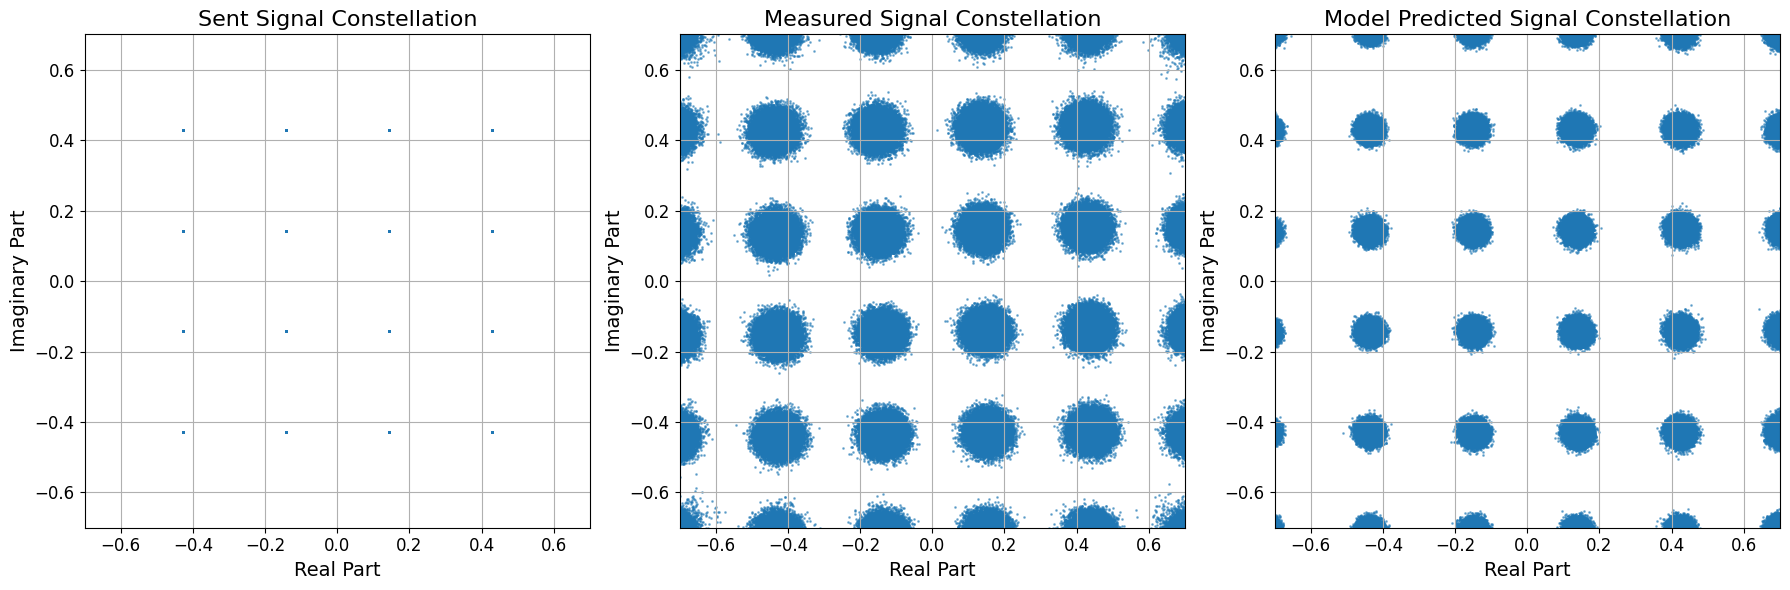

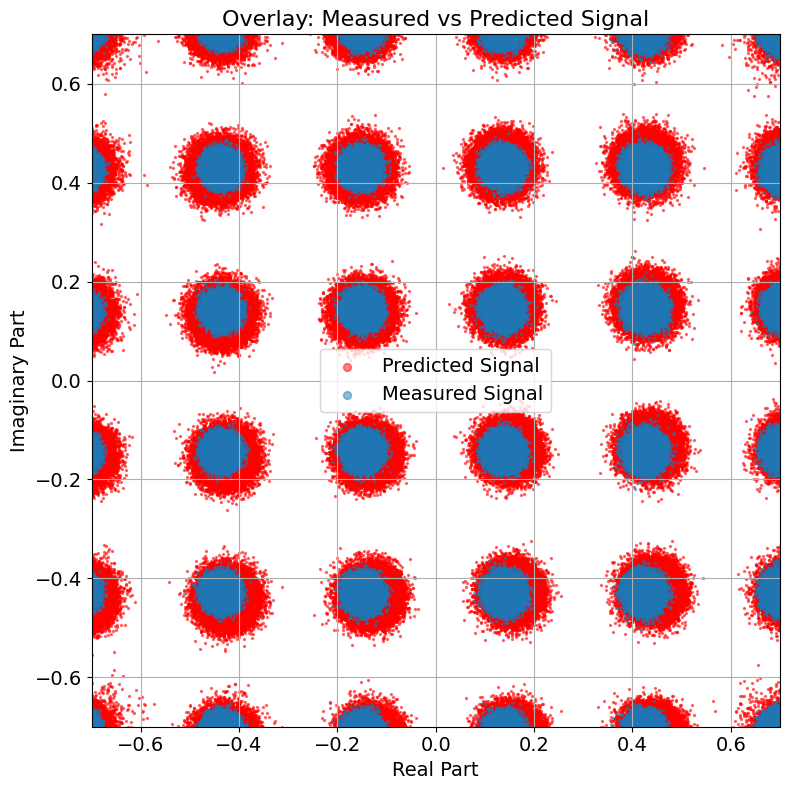

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import backend as K
import os
import traceback
from scipy.spatial import KDTree
from scipy.stats import entropy

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Define the working directory as the current directory
current_directory = os.getcwd()
print(f"Current working directory: {current_directory}")

# List files in the current directory
available_models = [f for f in os.listdir(current_directory) if os.path.isdir(os.path.join(current_directory, f))]

# Check if there are available models
if not available_models:
    print("No model directories available in the current directory.")
else:
    print("Available model directories:")
    for idx, model_name in enumerate(available_models):
        print(f"{idx + 1}: {model_name}")

    # Ask the user to choose a model
    while True:
        try:
            model_choice = int(input(f"Choose a model directory (1-{len(available_models)}): "))
            if 1 <= model_choice <= len(available_models):
                selected_model = available_models[model_choice - 1]
                print(f"Selected model directory: {selected_model}")
                break
            else:
                print(f"Please choose a number between 1 and {len(available_models)}.")
        except ValueError:
            print("Invalid input. Please enter a number.")

    # Full path of the selected model
    model_path = os.path.join(current_directory, selected_model)

    # Check if the model is a SavedModel directory
    if os.path.exists(model_path):
        print("Model file found.")
        try:
            # Check if it's a SavedModel directory
            if os.path.isdir(model_path) and os.path.exists(os.path.join(model_path, 'saved_model.pb')):
                vae_loaded = tf.keras.layers.TFSMLayer(model_path, call_endpoint='serving_default')
            else:
                vae_loaded = tf.keras.models.load_model(model_path)
            print("Model successfully loaded.")
        except Exception as e:
            print(f"Error loading the model: {e}")
            traceback.print_exc()
            vae_loaded = None
    else:
        print("Model file not found. Please check the file path.")
        vae_loaded = None

# Load new dataset
new_data = np.load('dataset/64qam/sent_data_tuple.npy')

# Load Measured data
received_data = np.load('dataset/64qam/received_data_tuple_sync-phase.npy')

batch_size = 32000  # Used for making predictions in batches to manage memory usage and improve performance

# Function to make batch predictions
def predict_in_batches(model, data, batch_size=batch_size):
    """
    Make predictions in batches to avoid memory issues.
    Args:
        model: The trained model to make predictions.
        data: Input data to be predicted.
        batch_size: Size of each batch for prediction.
    Returns:
        Concatenated predictions for all batches.
    """
    predictions = []
    num_batches = len(data) // batch_size + (1 if len(data) % batch_size != 0 else 0)
    for i in range(num_batches):
        batch_data = data[i * batch_size: (i + 1) * batch_size]
        batch_predictions = model(tf.constant(batch_data))['output_0']  # Adjust to access dictionary output
        predictions.append(batch_predictions)
    return tf.concat(predictions, axis=0)

# Make batch predictions
if vae_loaded is not None:
    new_predictions = predict_in_batches(vae_loaded, new_data, batch_size=batch_size)
    new_predictions_np = new_predictions.numpy()  # Convert to numpy array if necessary
    new_predictions_complex = new_predictions_np[:, 0] + 1j * new_predictions_np[:, 1]
    print("Predictions completed for the new dataset.\n")
else:
    print("Model was not loaded. Unable to make predictions.\n")

# Convert new_data and received_data to complex form
new_data_complex = new_data[:, 0] + 1j * new_data[:, 1]
received_data_complex = received_data[:, 0] + 1j * received_data[:, 1]

# Function to plot constellations
def plot_constellations(sent_data, received_data, predicted_data, axis_limits):
    """
    Plot signal constellations for sent, received, and predicted data.
    Args:
        sent_data: Original sent signal data (complex values).
        received_data: Measured signal data (complex values).
        predicted_data: Predicted signal data by the model (complex values).
        axis_limits: Axis limits for the constellation plot.
    """
    fig, axs = plt.subplots(1, 3, figsize=(18, 6))

    def plot_constellation(data, title, ax, axis_limits):
        """
        Helper function to plot a constellation diagram.
        Args:
            data: Complex data to plot.
            title: Title of the plot.
            ax: Axis object to plot on.
            axis_limits: Axis limits for the plot.
        """
        ax.scatter(data[:, 0], data[:, 1], s=1, alpha=0.5)
        ax.set_title(title, fontsize=16)
        ax.set_xlabel('Real Part', fontsize=14)
        ax.set_ylabel('Imaginary Part', fontsize=14)
        ax.grid(True)
        ax.tick_params(axis='both', which='major', labelsize=12)
        ax.set_xlim(axis_limits)
        ax.set_ylim(axis_limits)

    # Convert complex data to real and imaginary parts for plotting
    sent_data_combined = np.column_stack((sent_data.real, sent_data.imag))
    received_data_combined = np.column_stack((received_data.real, received_data.imag))
    predicted_data_combined = np.column_stack((predicted_data.real, predicted_data.imag))

    # Plot sent, received, and predicted constellations
    plot_constellation(sent_data_combined, "Sent Signal Constellation", axs[0], axis_limits)
    plot_constellation(received_data_combined, "Measured Signal Constellation", axs[1], axis_limits)
    plot_constellation(predicted_data_combined, "Model Predicted Signal Constellation", axs[2], axis_limits)

    plt.tight_layout()
    plt.show()

# Function to plot overlay of Measured and predicted constellations
def plot_overlay(received_data, predicted_data, axis_limits):
    """
    Plot overlay of Measured and predicted constellations.
    Args:
        received_data: Measured signal data (complex values).
        predicted_data: Predicted signal data by the model (complex values).
        axis_limits: Axis limits for the constellation plot.
    """
    fig, ax = plt.subplots(figsize=(8, 8))

    # Convert complex data to real and imaginary parts for plotting
    received_data_combined = np.column_stack((received_data.real, received_data.imag))
    predicted_data_combined = np.column_stack((predicted_data.real, predicted_data.imag))

    # Plot overlay of Measured and predicted constellations
    ax.scatter(predicted_data_combined[:, 0], predicted_data_combined[:, 1], s=2, alpha=0.5, label='Predicted Signal', color='red')
    ax.scatter(received_data_combined[:, 0], received_data_combined[:, 1], s=2, alpha=0.5, label='Measured Signal')
    
    ax.set_title("Overlay: Measured vs Predicted Signal", fontsize=16)
    ax.set_xlabel('Real Part', fontsize=14)
    ax.set_ylabel('Imaginary Part', fontsize=14)
    ax.grid(True)
    ax.set_xlim(axis_limits)
    ax.set_ylim(axis_limits)
    ax.legend(fontsize=14, loc='center', markerscale=4)
    ax.tick_params(axis='both', which='major', labelsize=14)

    plt.tight_layout()
    plt.show()

# Manually set axis limits for constellation plots
axis_limits = [-0.7, 0.7]  # Adjust limits as needed

# Plot constellations of the new dataset with manually defined axis limits
plot_constellations(new_data_complex, received_data_complex, new_predictions_complex, axis_limits)

# Plot overlay of Measured and predicted constellations
plot_overlay(new_predictions_complex,received_data_complex,  axis_limits)

# Clear session to free up resources
tf.keras.backend.clear_session()

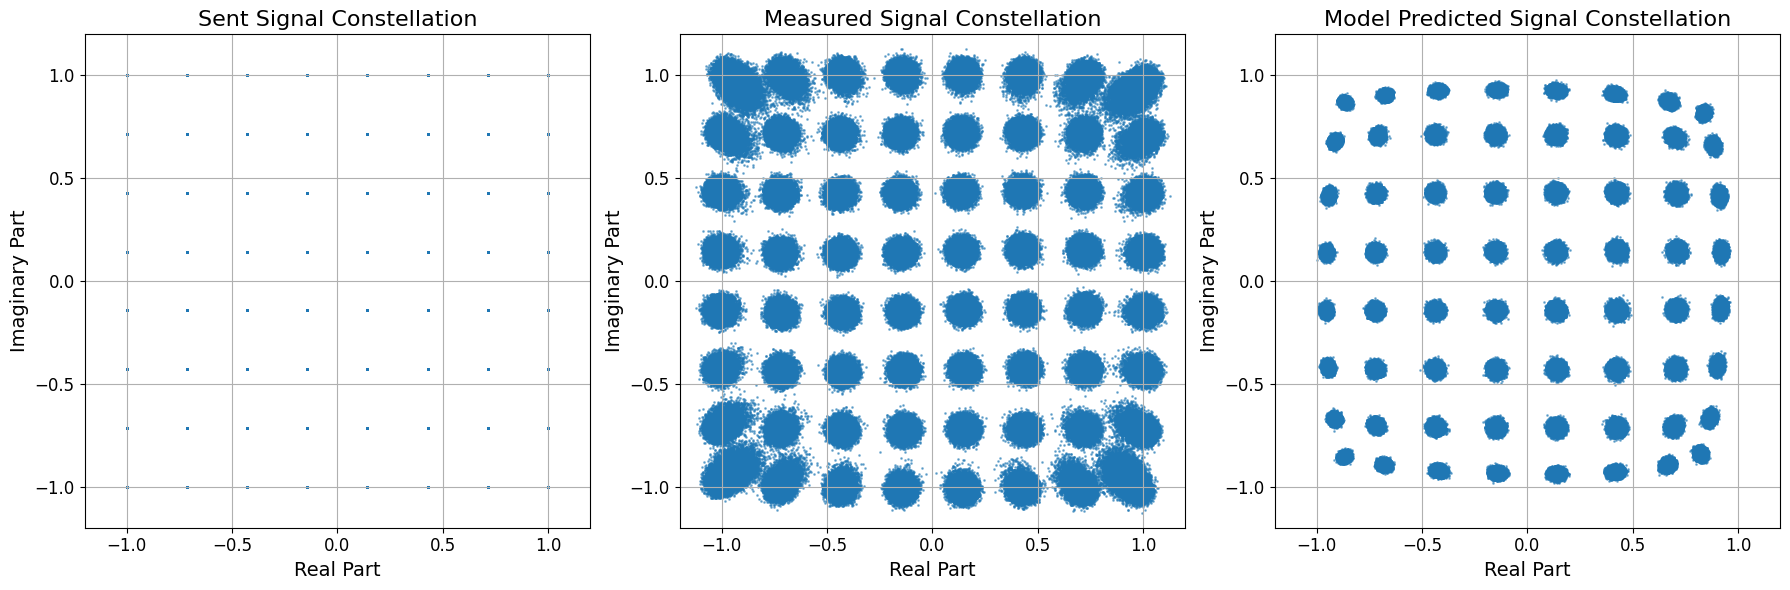

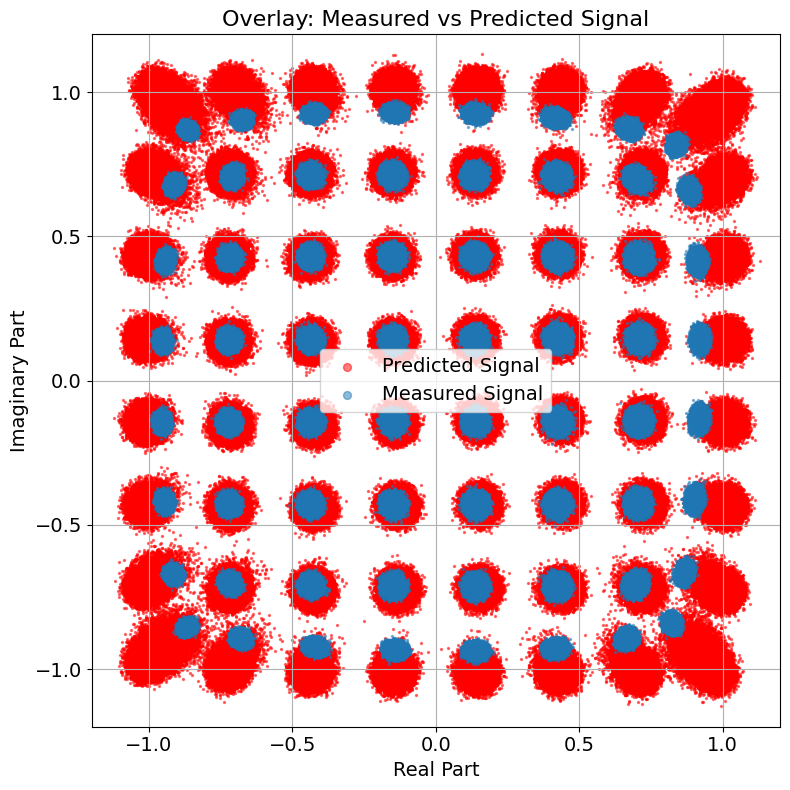

In [9]:

# Manually set axis limits for constellation plots
axis_limits = [-1.2, 1.2]  # Adjust limits as needed

# Plot constellations of the new dataset with manually defined axis limits
plot_constellations(new_data_complex, received_data_complex, new_predictions_complex, axis_limits)

# Plot overlay of Measured and predicted constellations
plot_overlay(new_predictions_complex,received_data_complex,  axis_limits)


AttributeError: 'list' object has no attribute 'real'

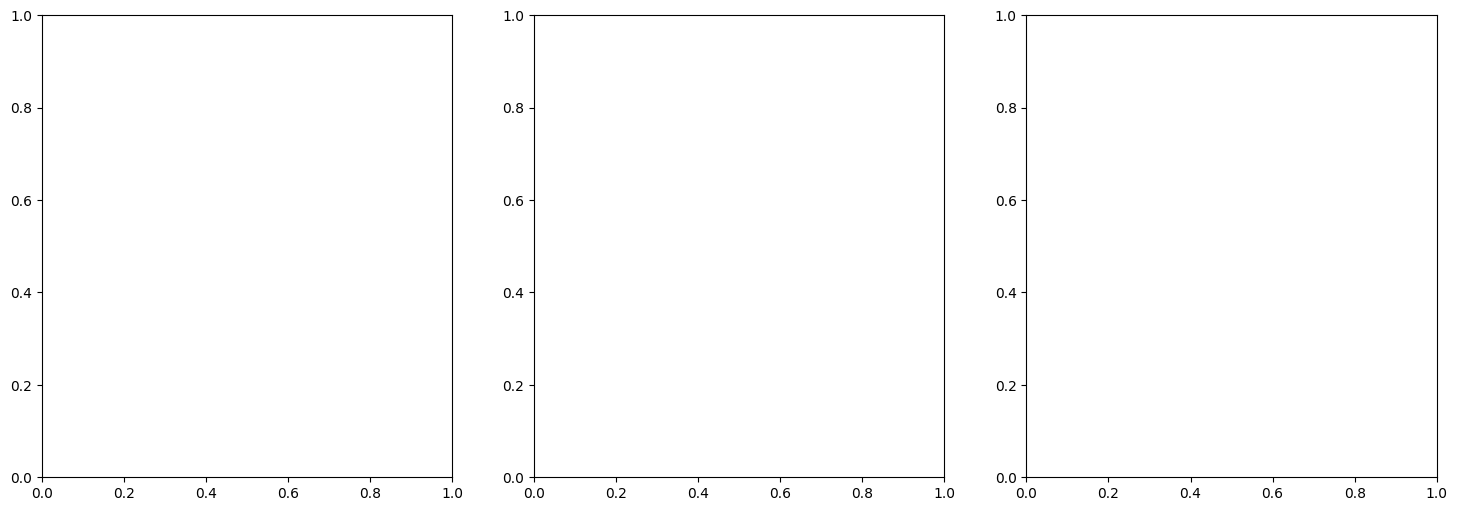

In [7]:
# Manually set axis limits for constellation plots
axis_limits = [-0.7, 0.7]  # Adjust limits as needed

# Plot constellations of the new dataset with manually defined axis limits
plot_constellations(new_data_complex, new_predictions_complex, axis_limits, received_data_complex)

# Plot overlay of Measured and predicted constellations
plot_overlay(received_data_complex, new_predictions_complex, axis_limits)

# Clear session to free up resources
tf.keras.backend.clear_session()